In [1520]:
from matplotlib import pyplot as plt
import numpy as np
import csv
from twython import Twython, TwythonError, TwythonRateLimitError
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import kneighbors_graph

CONSUMER_KEY = "qQnwG3pV3nQ2zwxyD3k5YLrmr"
CONSUMER_SECRET = "5nafarhIvc9wf8VcW4UoocUdjow4e9bzCK7CdkJOWtiMIbzGOx"
oauth_token = "364921636-Rg39exQcDjhawXLgmcgC5tcDXZcw6OXdapApOzkP"
oauth_secret = "JjuLoZMHOies5IzjT1lx2OKuNypeEeCtll5tgzxRCbSEV"

twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, oauth_token, oauth_secret)
basic_search = twitter.search(q='python', result_type='popular')

## Hydratation

In [2]:
def hydrate_database(filename, database_name, 
                     features, nb_requests, 
                     tweet_hydratation_limit=100):

    file = open(filename, "r")
    
    with open(database_name, 'w', newline='\n', encoding="utf-8") as csvfile:
        
        writer = csv.writer(csvfile,delimiter=',',quotechar='"',quoting=csv.QUOTE_ALL)
            
        lines = file.readlines()
        ids = [x[:-1] for x in lines]

        counter = 0
            
        while counter/100 < nb_requests:
            
            try:
                
                tweet_ids = ",".join(ids[counter:counter+100])
                statuses = twitter.lookup_status(id=tweet_ids)

                for status in statuses:
                    
                    output = []
                    
                    for feature in features:
                        element = status
                        for key in feature:
                            element = element[key]
                        output.append(element)
                    
                    if status["lang"] == "en":
                        writer.writerow(output)
            
            except TwythonError as e:
                if isinstance(e, TwythonRateLimitError):
                    retry_after = int(e.retry_after)
                    
                    time.sleep(retry_after-time.time())
                    
            counter += 100

    file.close()

In [560]:
# Mélange aléatoire des tweets

pd.read_csv("news.txt",header=None,names=["id"]).sample(frac=1).to_csv("random_news.txt",header=None,index=False)

In [564]:
filename = "random_news.txt"
database_name = "random_news.csv"
features = [['text'], ['user', 'screen_name']]
nb_requests = 900

hydrate_database(filename, database_name, features, nb_requests, tweet_hydratation_limit=100)

## Preprocessing

In [106]:
nlp = spacy.load("en_core_web_md")

In [1646]:
# Tokenization et nettoyage

df = pd.read_csv("random_news.csv",names=["tweet","user"],nrows=10000)

tweets = []

whitelist = ["ADJ","ADV","NOUN","PART","PROPN","VERB","ADP","SCONJ"]

to_delete = []

for i, row in df.iterrows():
    doc = nlp(row["tweet"].replace("’","'"))
    tweet = []
    if row["tweet"][0] == "@":
        to_delete.append(i)
        continue
    for token in doc:
        if token.pos_ in whitelist and not token.is_stop and not token.like_url and token.text not in ["\n","\t"] and not token.is_oov:
            clean_token = token.lemma_.lower()
            if clean_token not in ["rt","#","|","-","'","…"] and clean_token[0] != "@":
                tweet.append(clean_token)
    if len(tweet) < 3:
        to_delete.append(i)
        continue
    tweets.append(tweet)
    
df = df.drop(df.index[to_delete])

print("Taille de l'échantillon :",len(df))

Taille de l'échantillon : 9591


In [1700]:
# Vectorisation TFIDF

def rien(doc):
    return doc

tfidf = TfidfVectorizer(analyzer='word',tokenizer=rien,preprocessor=rien,token_pattern=None,min_df=10)
#tfidf = CountVectorizer(analyzer='word',tokenizer=rien,preprocessor=rien,token_pattern=None,min_df=15)

X = tfidf.fit_transform(tweets)

print("Taille du vocabulaire :",len(tfidf.vocabulary_))

Taille du vocabulaire : 1550


## Réduction de dimension

In [1701]:
# Choix de la méthode de réduction

method = "SVD"
#method = "PCA"

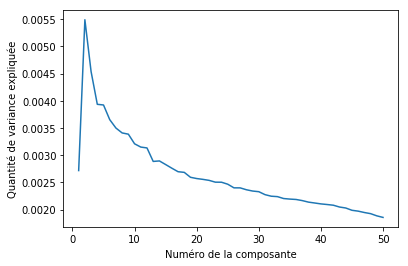

In [1702]:
# Variance expliquée par dimension

if method == "SVD":
    reduction = TruncatedSVD(n_components=50,random_state=0).fit(X)
else:
    reduction = PCA(n_components=50,random_state=0).fit(StandardScaler().fit_transform(X.todense()))

plt.plot(range(1,51),reduction.explained_variance_);
plt.xlabel("Numéro de la composante");
plt.ylabel("Quantité de variance expliquée");

In [1703]:
c = 12 # Nombre de composantes qu'on va prendre en compte pour la suite

ratios = reduction.explained_variance_ratio_.cumsum()
print("Variance expliquée avec",c,"composantes :",ratios[c-1]*100,"%")

Variance expliquée avec 12 composantes : 4.451657678260489 %


In [1704]:
# Application de la SVD

if method == "SVD":
    X_red = TruncatedSVD(n_components=c,random_state=0).fit_transform(X)
    X_red = Normalizer().fit_transform(X_red)
else:
    X_red = PCA(n_components=c,random_state=0).fit_transform(StandardScaler().fit_transform(X.todense()))

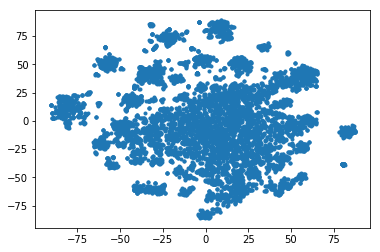

In [1705]:
# Visualisation des données

X_2D = TSNE(n_components=2,random_state=0,perplexity=30).fit_transform(X_red)
plt.scatter(X_2D[:,0], X_2D[:,1], marker=".");

## Clustering via K-means

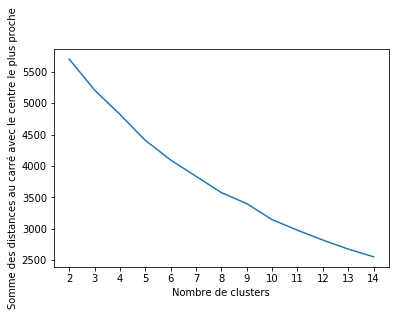

In [1715]:
# Trouver le nombre de clusters idéal

errors = []

for k in range(2,15):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_red)
    errors.append(kmeans.inertia_)

plt.plot(range(2,15),errors);
plt.xticks(range(2,15));
plt.xlabel("Nombre de clusters");
plt.ylabel("Somme des distances au carré avec le centre le plus proche");

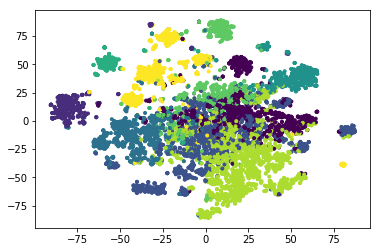

In [1716]:
# Application de K-means

kmeans = KMeans(n_clusters=9, random_state=0).fit(X_red)

Y = kmeans.labels_

plt.scatter(X_2D[:,0], X_2D[:,1], marker=".", c=Y);

In [1714]:
# Affichage des mots les plus fréquents pour chaque cluster

clusters = pd.DataFrame(X.todense()).groupby(Y).mean()
features = tfidf.get_feature_names()

for i,r in clusters.iterrows():
    print("Cluster",i)
    print(",".join([features[t] for t in np.argsort(r)[-6:][::-1]]),"\n")

Cluster 0
state,win,team,news,announce,girl 

Cluster 1
new,york,post,open,facebook,year 

Cluster 2
time,city,good,week,fire,come 

Cluster 3
man,police,woman,charge,find,kill 

Cluster 4
trump,president,donald,say,call,obama 

Cluster 5
day,big,national,st.,memorial,% 

Cluster 6
say,plan,report,u.s.,health,tax 

Cluster 7
photo,game,get,amp,want,take 

Cluster 8
school,year,county,today,high,student 



In [1698]:
# Affichage des comptes les plus représentatifs de chaque cluster

df["cluster"] = Y

for i,r in clusters.iterrows():
    print("Cluster",i,"(",len(df.loc[df["cluster"] == i]),"tweets)")
    cluster_users = df.loc[df["cluster"] == i].groupby("user")["user"].count()
    cluster_users = cluster_users.to_frame()
    print(cluster_users.nlargest(5,cluster_users.columns[0]))
    print("\n")

Cluster 0 ( 1233 tweets)
               user
user               
Independent      11
IndianExpress     8
FoxNews           7
allafrica         6
politico          6


Cluster 1 ( 559 tweets)
                 user
user                 
Reuters             5
ABCPolitics         4
Independent         4
Slate               4
businessinsider     4


Cluster 2 ( 1722 tweets)
                 user
user                 
Independent        17
IndianExpress      11
businessinsider    10
CNBC                8
FoxNews             8


Cluster 3 ( 1045 tweets)
               user
user               
Independent      13
IndianExpress    11
CBSNews           9
wbaltv11          9
allafrica         7


Cluster 4 ( 613 tweets)
                user
user                
thehill           25
Independent       12
washingtonpost    12
politico          10
CNN                8


Cluster 5 ( 280 tweets)
                user
user                
ndtv               4
chicagotribune     3
BBCNews            2
Dai

In [1699]:
# Affichage de tweets au hasard pour chaque cluster

for i,r in clusters.iterrows():
    print("Cluster",i)
    cluster_tweets = df.loc[df["cluster"] == i][["tweet"]].values
    np.random.shuffle(cluster_tweets)
    for t in cluster_tweets[:5]:
        print(t)
    print("\n")

Cluster 0
["State helps Hoosiers get 'Cash for College': Indiana Commissioner for Higher Education Teresa Lubbers met with... https://t.co/U9JpxhrOuw"]
['RT @davesouthorn: Sanders is wide left. First half ends with Boise State up 14-7.']
['Safety engineer leader discusses risk, challenges https://t.co/fJ3nJmv4zw']
['Brewers by position: Eric Thames has something to prove at first base. https://t.co/JfII7eSplH https://t.co/oQJaMPum5O']
['Cozy Tillerson-Erdogan meeting in Turkey raises hope for warming ties https://t.co/NLqmD3MoYv']


Cluster 1
['Glenn Thrush of the New York Times was suspended today following accusations of sexual misconduct. https://t.co/Qp1ynA0Rj4']
["With a new moon on Saturday, it'll be prime viewing conditions for the Leonid meteor shower this weekend 🌌 https://t.co/P0JkzT16Yn"]
['The new #Spokane Journal: building activity, workforce education, SafeGuard startup, and a Kalispel land purchase:… https://t.co/NhQoW8srgr']
['As Chief Nursing Officer of the new Summit 

## Clustering via DBSCAN

[0.08533984 0.08198014 0.07973195 0.07746304 0.07592155 0.07402169
 0.06332365 0.0572291  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


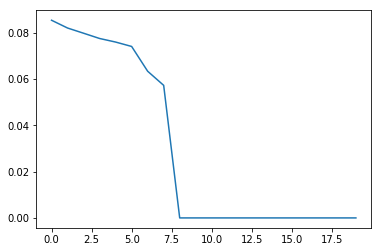

In [1630]:
# Trouver le epsilon idéal

A = kneighbors_graph(X_red, 9, mode="distance", include_self=True)
distances = np.sort(A.toarray()[-1,:])[::-1]
print(distances[:20])
plt.plot(distances[:20])

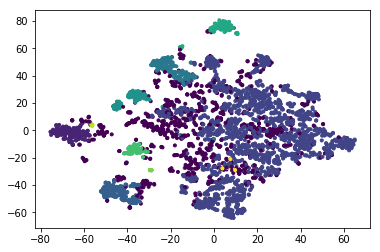

In [1644]:
# Application de DBSCAN

dbscan = DBSCAN(eps=.29, min_samples=10).fit(X_red)

Y = dbscan.labels_

plt.scatter(X_2D[:,0], X_2D[:,1], marker=".", c=Y)

In [1645]:
# Affichage des mots les plus fréquents pour chaque cluster

df = pd.DataFrame(X.todense()).groupby(Y).mean()
features = tfidf.get_feature_names()

for i,r in df.iterrows():
    print("Cluster",i)
    print(",".join([features[t] for t in np.argsort(r)[-10:]]),"\n")

Cluster -1
day,read,trump,president,year,post,world,facebook,video,new 

Cluster 0
member,book,video,week,life,look,open,restaurant,york,new 

Cluster 1
come,woman,police,home,game,today,man,city,state,say 

Cluster 2
decision,kim,house,white,obama,call,say,donald,president,trump 

Cluster 3
girl,college,gun,program,elementary,district,team,student,high,school 

Cluster 4
go,st.,independence,christmas,happy,celebrate,rip,gallery,photo,day 

Cluster 5
case,official,lift,girl,january,school,orange,sheriff,today,county 

Cluster 6
page,syrian,govt,remember,josh,sentence,past,celebrate,old,year 

Cluster 7
figure,fight,fifth,field,festival,fest,female,fellow,film,“ 

Cluster 8
york,leadership,professor,lack,approach,weigh,bank,associated,new,state 

Cluster 9
march,uber,seek,women,key,strong,option,job,protester,run 

